In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections as mc

from src.datasets import get_dataset
from src.modules import get_model, get_loss_fn, get_optimizer


In [3]:
class Snapshot:

    def __init__(self, dir_path, label0, label1, epoch, seed):
        self.dir_path = dir_path
        self.label0 = label0
        self.label1 = label1
        self.epoch = epoch
        self.seed = seed

    def __call__(self):
        path = f"{self.dir_path}/{self.label0}/gradient-{self.label1}-{self.epoch}.pt"
        if os.path.exists(path):
            return torch.load(path)
        data = self._process()
        torch.save(data, path)
        return data

    def _process(self):
        self._setup()
        s0 = self._snapshot()
        self._epoch()
        s1 = self._snapshot()
        return {k: (v, s1[k]-v) for k, v in s0.items()}

    def _setup(self):

        with open(f"{self.dir_path}/{self.label1}/config.json") as f:
            config = json.load(f)
        self.dataset = get_dataset(config["dataset"], "datasets")
        self.model = get_model(config["model"], self.dataset.input_shape, self.dataset.num_classes)
        self.model.set_epoch(self.epoch)
        self.loss_fn = get_loss_fn(config["fit"]["loss_fn"])
        self.num_samples = config["fit"]["num_samples"]
        config["fit"]["learning_rate"] = 1e-3
        self.optimizer = get_optimizer(config["fit"]["optimizer"], self.model.parameters())

        path = f"{self.dir_path}/{self.label0}/checkpoint-{self.epoch}.pt"
        state = torch.load(path, map_location="cpu")
        self.model.load_state_dict(state["model"])
        self.optimizer.load_state_dict(state["optimizer"])

    def _epoch(self):
        self.model.eval()
        self.model.train()
        torch.manual_seed(self.seed)

        dataloader = self.dataset.train_loader
        desc = f"{self.label1}/{self.label0}@{self.epoch}"
        progress = tqdm(dataloader, desc=desc)
        for inputs, targets in progress:
            inputs = inputs.unsqueeze(0).expand(self.num_samples, *inputs.shape)
            targets = targets.unsqueeze(0).expand(self.num_samples, *targets.shape)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            losses = self.loss_fn(outputs, targets)
            losses.mean().backward()
            self.optimizer.step()

    def _snapshot(self):
        snapshot = {}
        self._weight(snapshot)
        self._state(snapshot)
        return snapshot

    def _state(self, snapshot):
        for i in range(2, 14, 2):
            s0 = self.model.get_buffer(f"{i}.train_agg.s0").detach().clone()
            s1 = self.model.get_buffer(f"{i}.train_agg.s1").detach().clone()
            s2 = self.model.get_buffer(f"{i}.train_agg.s2").detach().clone()
            snapshot[f"{i}.state.m1"] = s1 / s0
            snapshot[f"{i}.state.m2"] = s2 / s0

    def _weight(self, snapshot):
        for i in range(1, 14, 4):
            b = self.model.get_parameter(f"{i}.bias").detach().clone()
            w = self.model.get_parameter(f"{i}.weight").detach().clone()
            if i < 14-1:
                snapshot[f"{i}.bias"] = b
                snapshot[f"{i}.weight.1t"] = w @ w.T
            if i > 1:
                snapshot[f"{i}.weight.t1"] = w.T @ w


In [81]:
def plot_segments(ax, x0, y0, x1, y1):

    dx = x1 - x0
    dy = y1 - y0
    r = (dx.square() + dy.square() + 1e-8).sqrt()
    n = (r*10).tanh()*2 / r
    c = yuv_color(0.5, dx*n, dy*n)
    ax.scatter(x0, y0, s=1, c=c)

    lc = mc.LineCollection(torch.stack([
        torch.stack([x0, x1], -1), torch.stack([y0, y1], -1)
    ], -1), colors=[tuple(v) for v in c], linewidth=0.5)
    ax.add_collection(lc)

def yuv_color(y, u, v):
    r = y + (1.370705 * v)
    g = y - (0.698001 * v) - (0.337633 * u)
    b = y + (1.732446 * u)
    r = r.clamp(0, 1)
    g = g.clamp(0, 1)
    b = b.clamp(0, 1)
    return torch.stack([r, g, b], -1)

def get_weight(ckpt, i, flip=False):
    w = ckpt["model"][f"{i}.weight"]
    if flip:
        w = w.T
    return w.T @ w

def get_state(ckpt, i):
    s0 = ckpt["model"][f"{i}.train_agg.s0"]
    s2 = ckpt["model"][f"{i}.train_agg.s2"]
    return s2 / s0

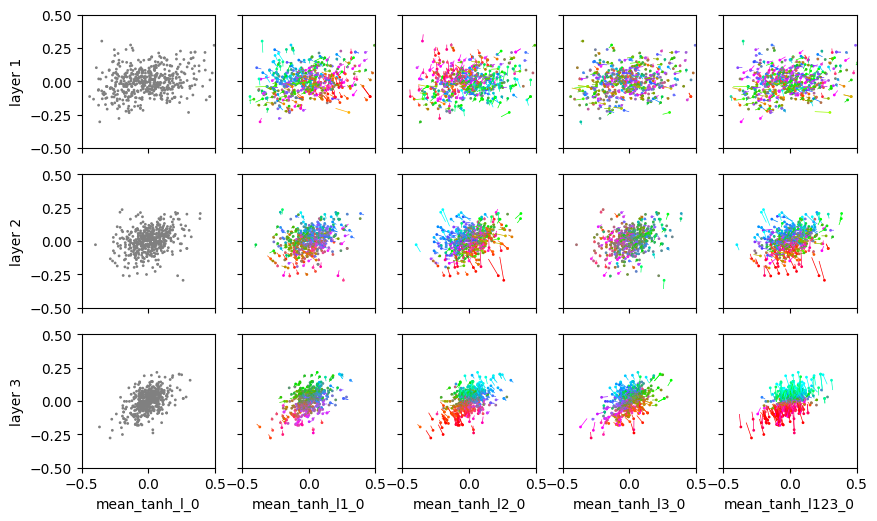

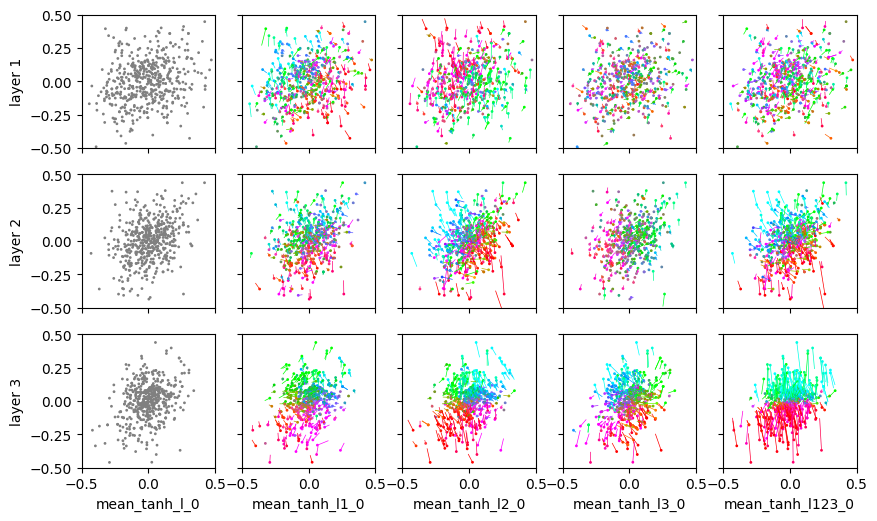

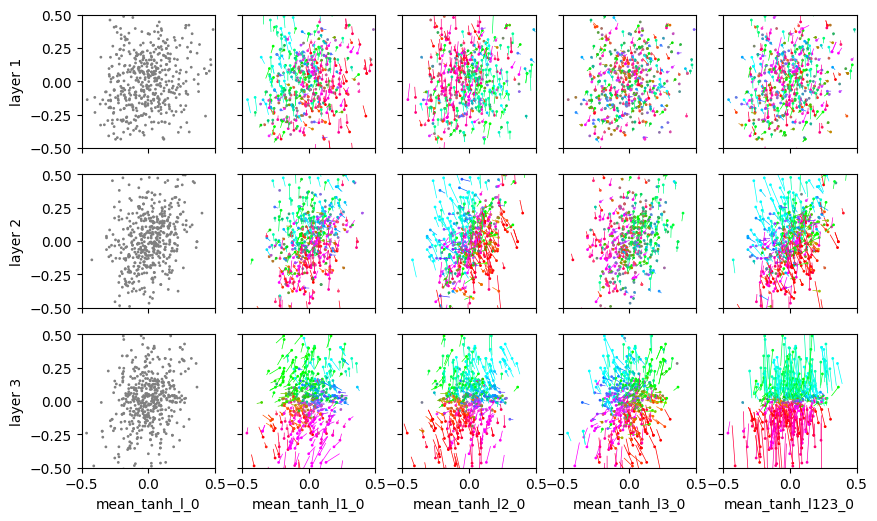

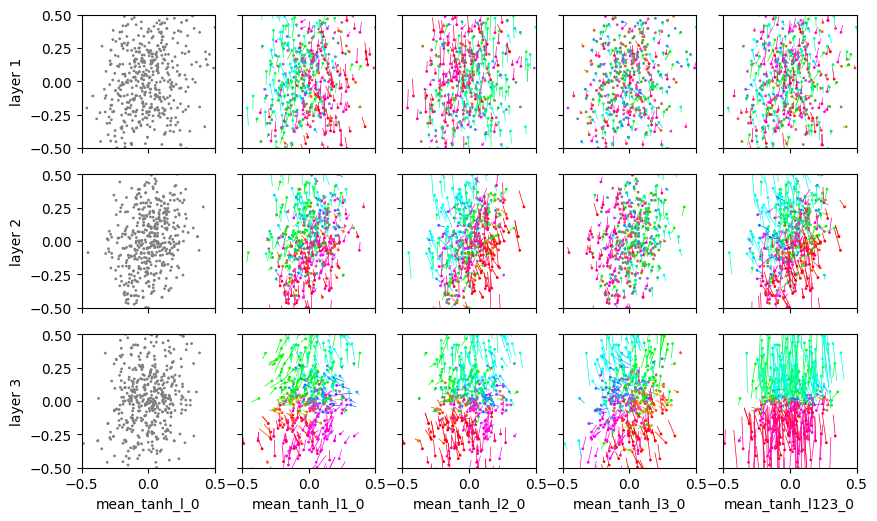

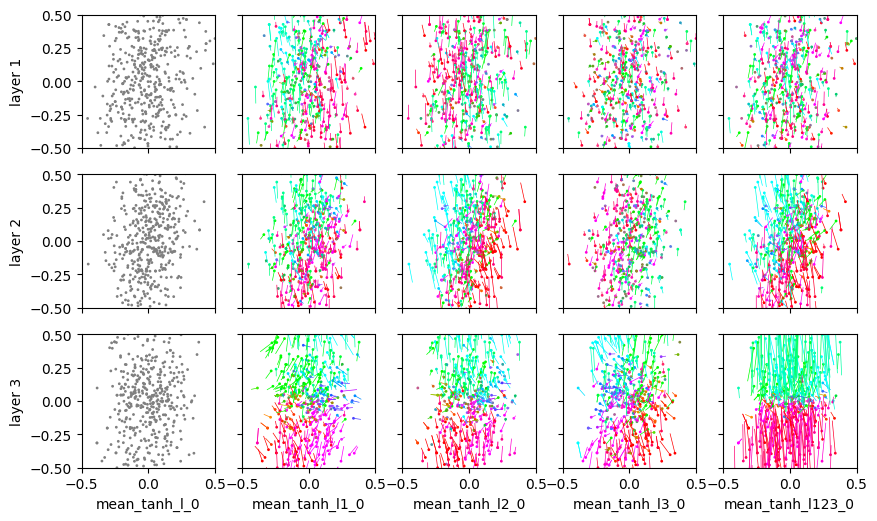

In [84]:
seed = 2020883518546164801
dir_path = "outputs/lyr"
labels = [f"mean_tanh_{l}_0" for l in ("l", "l1", "l2", "l3", "l123")]
layers = ["layer 1", "layer 2", "layer 3"]
epochs = [10, 20, 30, 40, 50]

n = 100
idx = torch.randint(n * (n-1), size=(500,))
idx = idx + (idx/n).int() + 1

for epoch in epochs:
    nrows, ncols = len(layers), len(labels)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, 
        sharex=True, sharey=True, dpi=100, figsize=(ncols*2, nrows*2))
    for j, label in enumerate(labels):
        s = Snapshot(dir_path, labels[0], label, epoch, seed)()
        t = Snapshot(dir_path, labels[0], labels[0], epoch, seed)()
        rx, ry = .5, .5
        speed = 1
        for i, layer in enumerate(layers):
            ax = axes[i][j]
            #kx = f"{i*4+1}.weight.1t"
            #kx = f"{i*4+2}.state.m2"
            kx = f"{i*4+4}.state.m2"
            ky = f"{i*4+5}.weight.t1"
            x0 = s[kx][0].flatten()[idx]
            y0 = s[ky][0].flatten()[idx]
            dx = s[kx][1].flatten()[idx] - t[kx][1].flatten()[idx]
            dy = s[ky][1].flatten()[idx] - t[ky][1].flatten()[idx]
            x1 = x0 + dx * speed
            y1 = y0 + dy * speed
            plot_segments(ax, x0, y0, x1, y1)
            ax.set_xlim(-rx, rx)
            ax.set_ylim(-ry, ry)
            if j == 0: ax.set_ylabel(layer)
            if i == len(layers)-1: ax.set_xlabel(label)

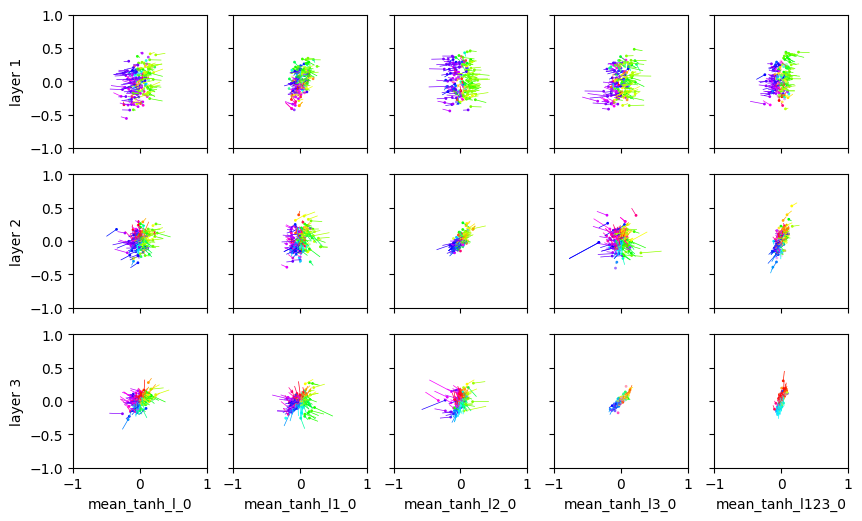

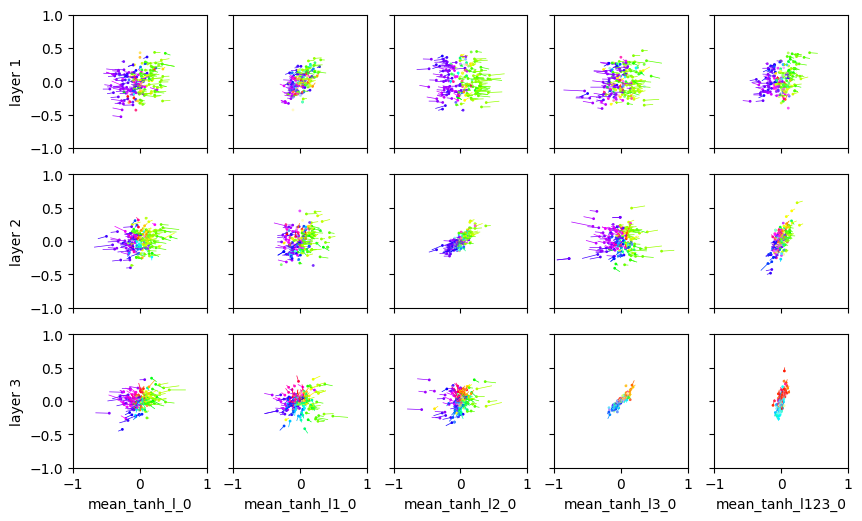

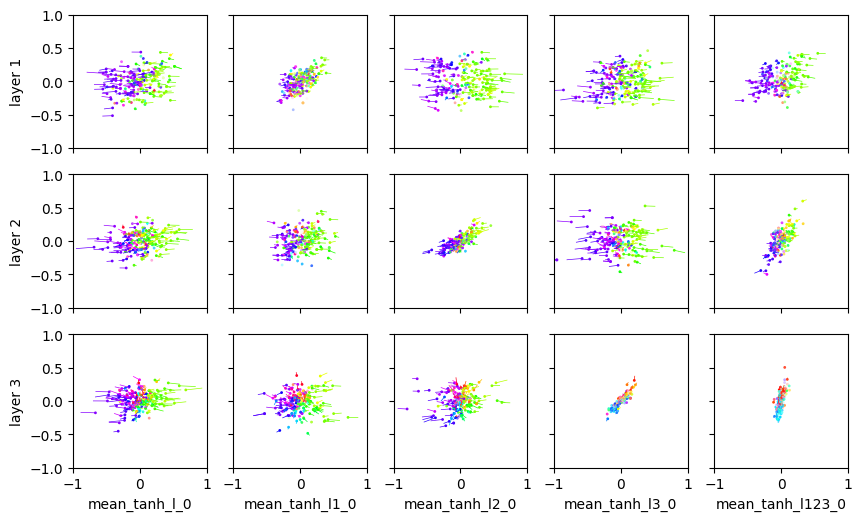

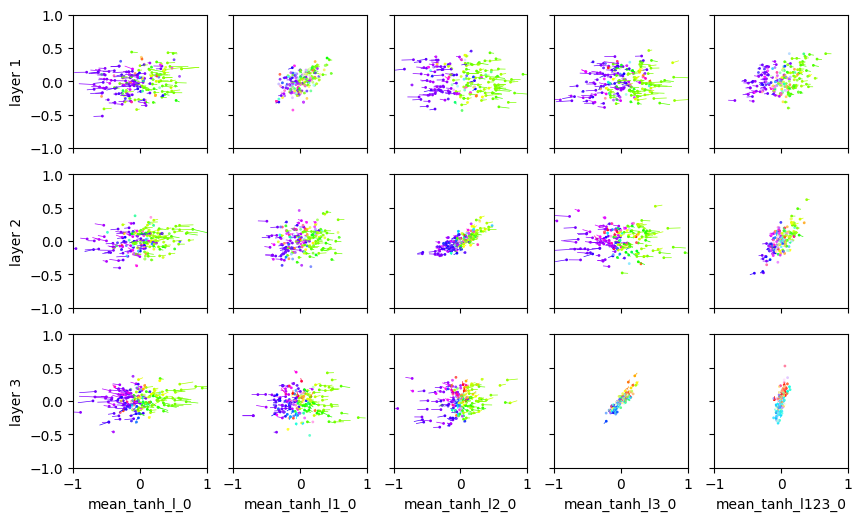

In [55]:
dir_path = "outputs/lyr"
labels = [f"mean_tanh_{l}_0" for l in ("l", "l1", "l2", "l3", "l123")]
layers = ["layer 1", "layer 2", "layer 3"]
epochs = [10, 20, 30, 40, 50]
r = 1

idx = torch.randint(100*100, size=(200,))
step = 10
a = 10 / step
for epoch1 in epochs[1:]:
    epoch0 = epoch1 - step
    nrows, ncols = len(layers), len(labels)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, 
        sharex=True, sharey=True, dpi=100, figsize=(ncols*2, nrows*2))
    for j, label in enumerate(labels):
        try:
            ckpt0 = torch.load(f"{dir_path}/{label}/checkpoint-{epoch0}.pt", map_location="cpu")
            ckpt1 = torch.load(f"{dir_path}/{label}/checkpoint-{epoch1}.pt", map_location="cpu")
        except Exception:
            continue
        for i, layer in enumerate(layers):
            ax = axes[i][j]

            y0 = get_state(ckpt0, i*4+4).fill_diagonal_(torch.nan).flatten()[idx]
            y1 = get_state(ckpt1, i*4+4).fill_diagonal_(torch.nan).flatten()[idx]
            x0 = get_weight(ckpt0, i*4+5).fill_diagonal_(torch.nan).flatten()[idx]
            x1 = get_weight(ckpt1, i*4+5).fill_diagonal_(torch.nan).flatten()[idx]
            plot_segments(ax, x0, y0, x0+(x1-x0)*a, y0+(y1-y0)*a)

            ax.set_xlim(-r, r)
            ax.set_ylim(-r, r)
            if j == 0: ax.set_ylabel(layer)
            if i == len(layers)-1: ax.set_xlabel(label)
